In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7026/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)

In [5]:
width = 0.015
ang = jnp.pi
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    17,17,101
)

In [6]:
enumerators = b.make_enumerator(["contact_params_1"])

In [10]:
def make_orientation_posterior_viz(observation, gt_contact, sampled_contacts):
    fig = plt.figure(constrained_layout=True)
    # fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_contacts[:,2]),jnp.cos(sampled_contacts[:,2]),label="Posterior Samples", alpha=0.5, s=15)
    ax.scatter(-jnp.sin(gt_contact[2]),jnp.cos(gt_contact[2]), color=(1.0, 0.0, 0.0),label="Actual", alpha=0.9, s=10)
    ax.set_title("Posterior on Orientation (top view)")
    ax.legend(fontsize=9)
    # plt.show()
    return fig

key = jax.random.PRNGKey(10)

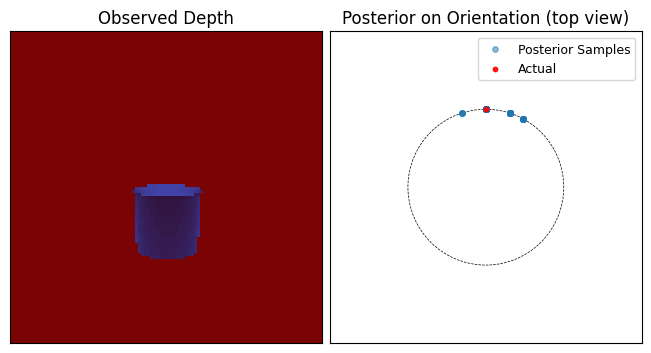

In [18]:
key = jax.random.split(key, 1)[0]
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(21),
    "id_1": jnp.int32(13),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 3,
    "face_child_1": 2,
    "variance": 0.0001,
    "outlier_prob": 0.001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.1, -0.1, -jnp.pi]), jnp.array([0.1, 0.1, jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)
b.show_trimesh("1", b.RENDERER.meshes[13])
b.set_pose("1", b.get_poses(trace)[1])

contact_param_grid = trace["contact_params_1"] + contact_param_deltas
weights =  jnp.concatenate([
    enumerators[3](trace, key, cp)
    for cp in jnp.array_split(contact_param_grid, 50)
],axis=0)
sampled_indices = jnp.unravel_index(jax.random.categorical(key, weights.reshape(-1), shape=(100,)), weights.shape)[0]
sampled_contact_params = contact_param_grid[sampled_indices]

fig = make_orientation_posterior_viz(trace["image"], trace["contact_params_1"], sampled_contact_params)
# fig.savefig(f'mug_results/{1:05d}.png')


True
-15713.372
-15718.267


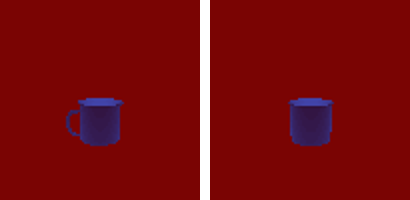

In [13]:
new_trace = enumerators[0](trace, key, sampled_contact_params[sampled_contact_params[:,2].argmax()])
print(trace.get_score() > new_trace.get_score())
print(trace.get_score())
print(new_trace.get_score())
b.viz_trace_meshcat(new_trace)
b.viz_trace_rendered_observed(new_trace)

In [17]:
def get_filter_points(ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    

In [18]:
def get_pixelwise_scores(trace, filter_size):
    log_scores_per_pixel = b.threedp3_likelihood_per_pixel_jit(
        trace["image"],
        b.genjax.get_rendered_image(trace),
        trace["variance"],
        trace["outlier_prob"],
        b.genjax.get_outlier_volume(trace),
        b.genjax.get_focal_length(trace),
        filter_size
    )
    return log_scores_per_pixel


In [19]:
b.genjax.get_focal_length(trace)

AttributeError: module 'genjax' has no attribute 'get_focal_length'

In [18]:
b.genjax.get_outlier_volume(trace)

Array(1., dtype=float32, weak_type=True)

In [19]:
jnp.save("hello.npz", (new_trace["image"], b.genjax.get_rendered_image(new_trace)))

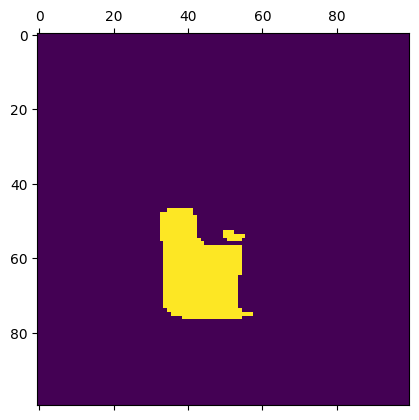

In [20]:
scores1 = get_pixelwise_scores(trace, 3)
scores2 = get_pixelwise_scores(new_trace, 3)
plt.matshow(scores2 > scores1)
b.show_cloud("better", trace["image"][scores2 > scores1,:].reshape(-1,3), color=b.BLUE)

-67209.95
-67140.664


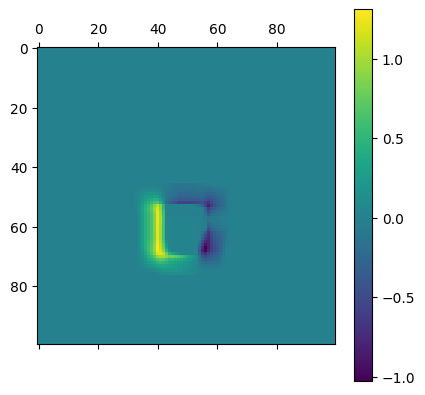

In [21]:
scores1 = get_pixelwise_scores(trace, 3)
scores2 = get_pixelwise_scores(new_trace, 3)
print(scores1.sum())
print(scores2.sum())
plt.matshow(scores2 - scores1)
plt.colorbar()

In [ ]:
def threedp3_likelihood_per_pixel_at_pixel(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    focal_length,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    log_probabilities = gausssian_mixture_vectorize(
        indices, observed_xyz,
        rendered_xyz_padded,
        variance, outlier_prob, outlier_volume,
        focal_length,
        filter_size
    )

In [18]:
b.genjax.viz_trace_meshcat(new_trace)

In [69]:
logerf  = lambda x: jnp.logaddexp(0.0, jnp.log(2) + jax.scipy.stats.norm.logcdf(x * jnp.sqrt(2)))

In [78]:
p = trace["image"][10,10]
focal_length = b.genjax.get_focal_length(trace)
filter_latent = b.genjax.get_rendered_image(trace)[7:13,7:13,:]
variance = trace["variance"]
variance = 0.0001
from jax.scipy.special import logsumexp, erf

half_widths = (filter_latent[:, :, 2] / focal_length) / 2.0

delta = jnp.stack([half_widths, half_widths, jnp.zeros_like(half_widths)],axis=-1)
bottom_lefts = filter_latent - delta
top_rights =  filter_latent + delta

sigma = jnp.sqrt(variance)
C = (2*jnp.pi)**(-3/2)  * sigma**(-3)

z_term = - (p[2] - bottom_lefts[:,:,2])**2/sigma**2
x_term = jnp.log(jnp.sqrt(jnp.pi) * sigma / 2) +  jnp.logaddexp(
                                                    logerf((p[0] - 2*bottom_lefts[:,:,0]) / sigma), 
                                                 logerf((- p[0] + bottom_lefts[:,:,0] + top_rights[:,:,0]) / sigma))
y_term = jnp.log(jnp.sqrt(jnp.pi) * sigma / 2) + jnp.logaddexp(logerf((p[1] - 2*bottom_lefts[:,:,1]) / sigma),logerf((- p[1] + bottom_lefts[:,:,1] + top_rights[:,:,1]) / sigma))

log_probabilities_per_latent = x_term + y_term + z_term
probability = logsumexp(log_probabilities_per_latent)- jnp.log(((2*half_widths)**2).sum())
probability

Array(2.531024, dtype=float32)

In [53]:
(p[0] - 2*bottom_lefts[:,:,0]) / sigma

Array([[14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426],
       [14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426],
       [14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426],
       [14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426],
       [14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426],
       [14.862703, 14.230248, 13.597793, 12.965337, 12.332882, 11.700426]],      dtype=float32)

In [29]:
p

Array([-0.39999998, -0.39999998,  2.        ], dtype=float32)

In [32]:
filter_latent[3,3]

Array([-0.39999998, -0.39999998,  2.        ], dtype=float32)

In [28]:
probabilities_per_latent

Array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [24]:
erf((- p[0] + bottom_lefts[:,:,0] + top_rights[:,:,0]) / sigma)

Array([[-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.]], dtype=float32)

In [26]:
top_rights[:,:,0]

Array([[-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ],
       [-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ],
       [-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ],
       [-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ],
       [-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ],
       [-0.42499998, -0.415     , -0.405     , -0.39499998, -0.385     ,
        -0.375     ]], dtype=float32)

In [27]:
 bottom_lefts[:,:,0]

Array([[-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ],
       [-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ],
       [-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ],
       [-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ],
       [-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ],
       [-0.43499997, -0.42499998, -0.415     , -0.40499997, -0.39499998,
        -0.385     ]], dtype=float32)

In [ ]:
 bottom_lefts[:,:,0]3

In [17]:
log_scores_per_pixel.max()

Array(8.668539, dtype=float32)

In [11]:
new_trace.get_score()

Array(nan, dtype=float32)

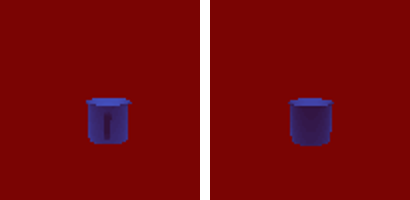

In [10]:
new_trace = enumerators[0](trace, key, sampled_contact_params[sampled_contact_params[:,2].argmin()])
b.genjax.viz_trace_rendered_observed(new_trace)

 40%|██████████████████████▍                                 | 20/50 [00:23<00:34,  1.14s/it]/var/tmp/ipykernel_3952339/1931699082.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True)
100%|████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


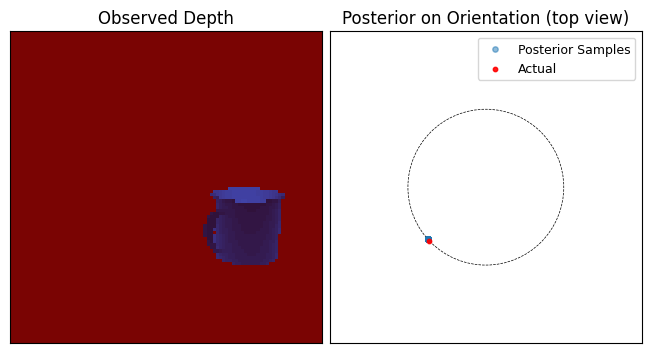

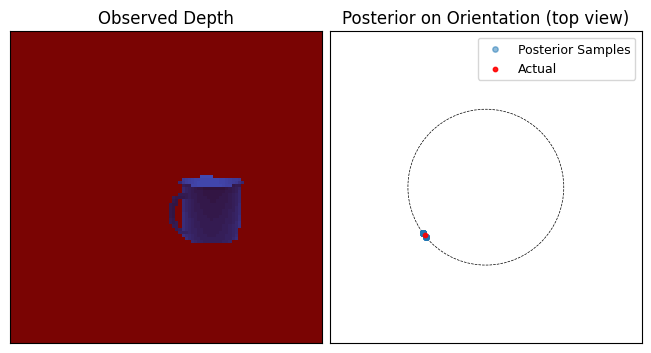

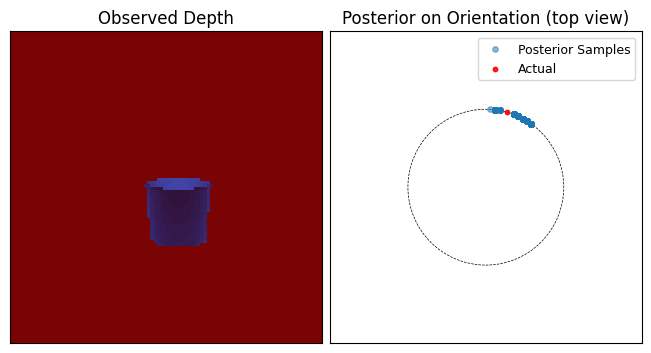

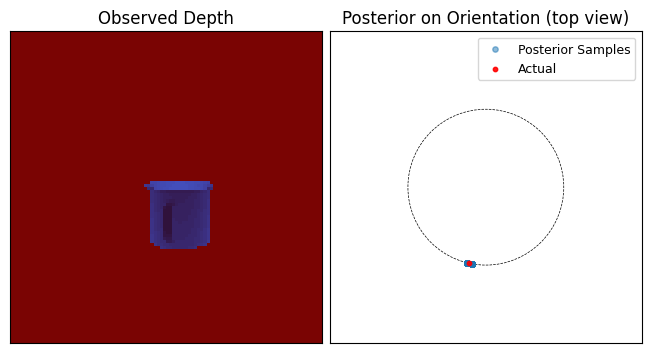

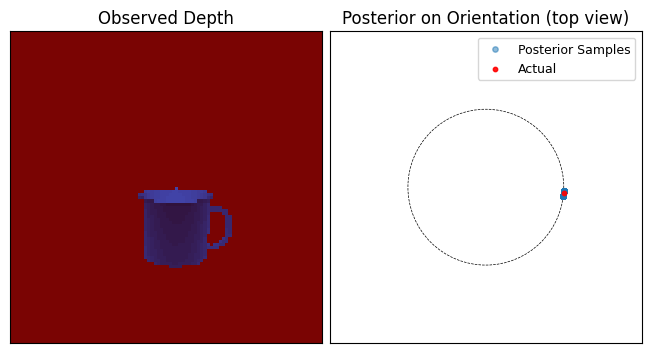

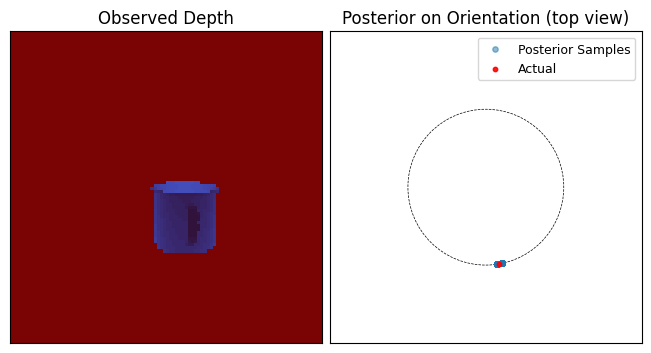

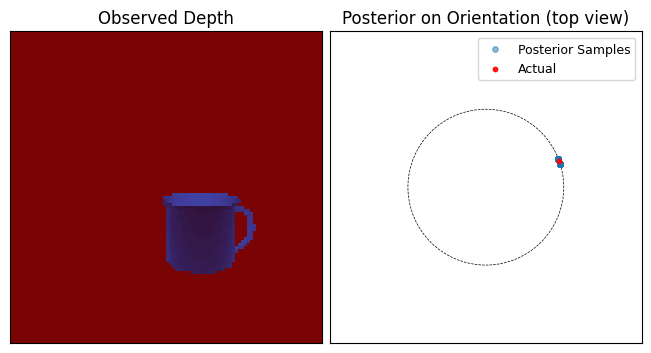

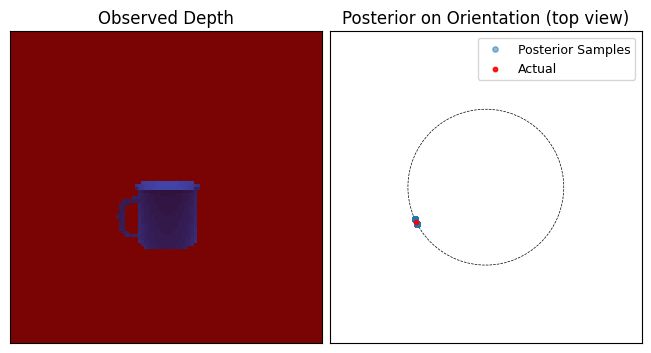

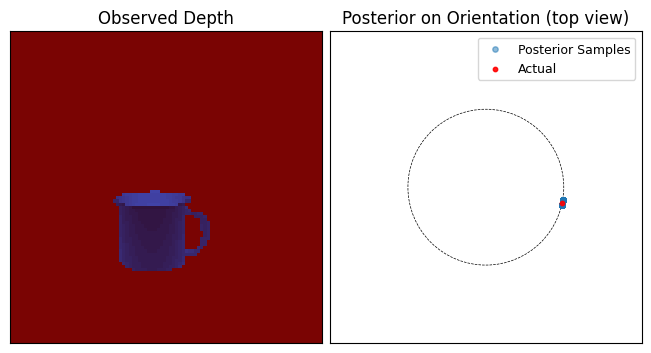

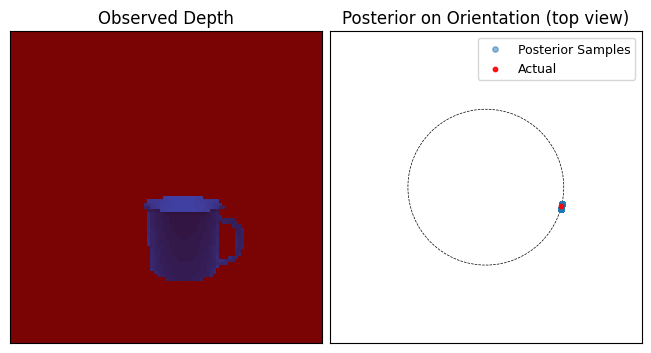

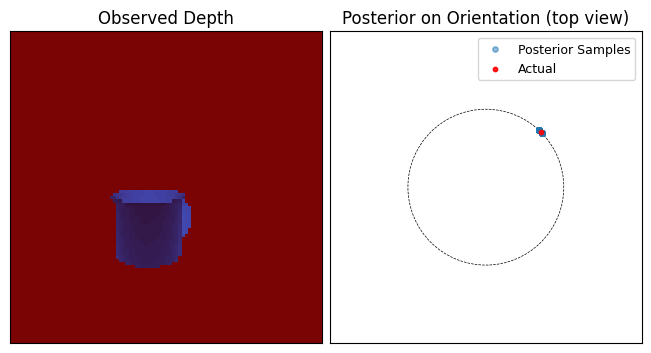

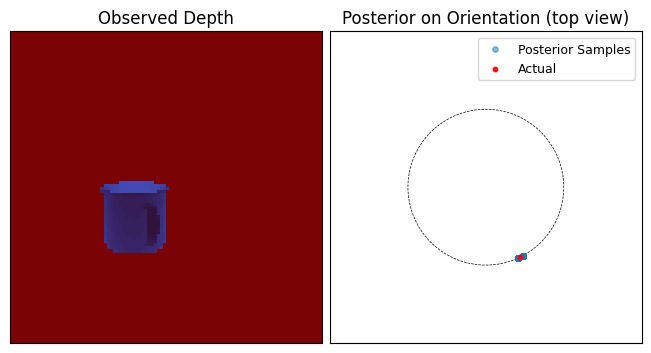

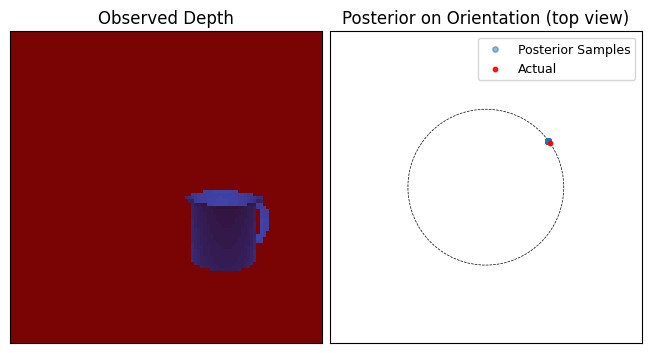

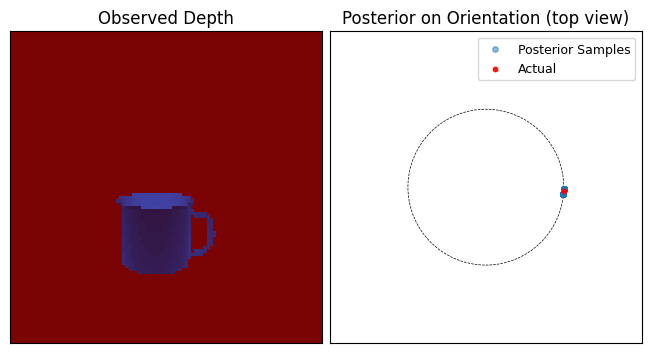

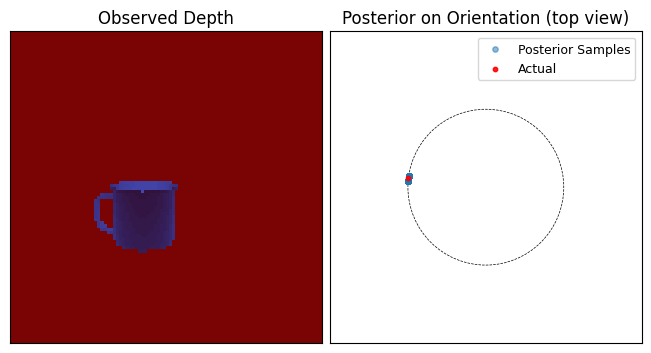

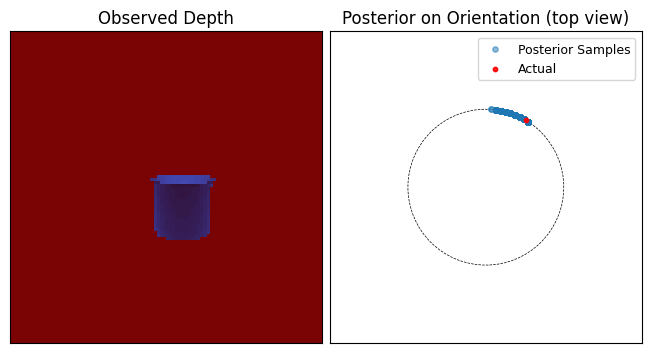

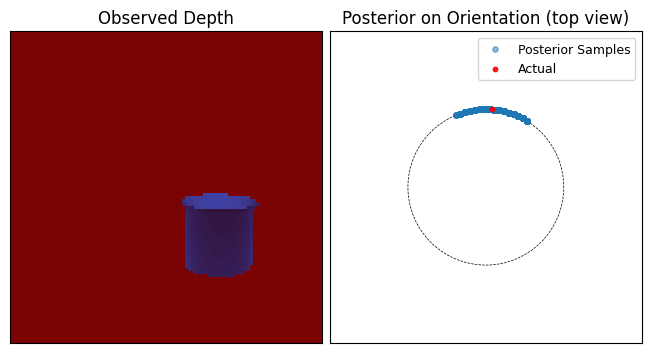

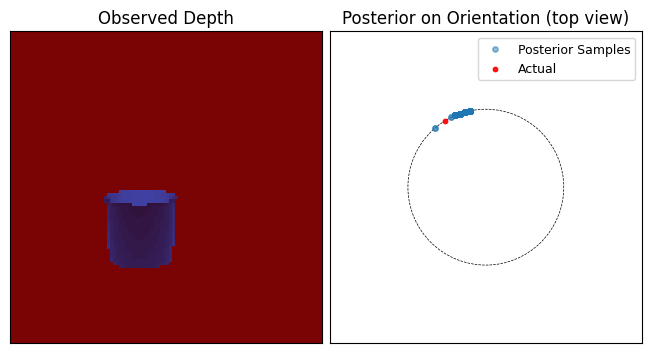

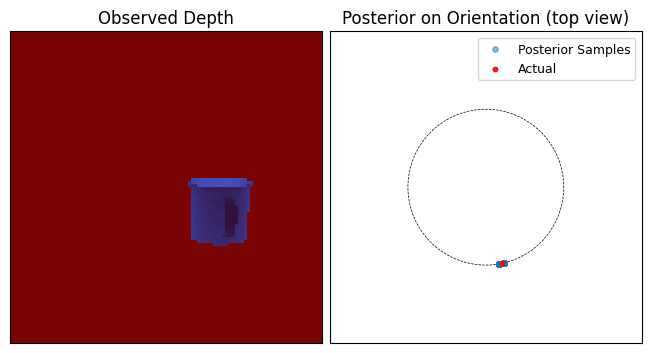

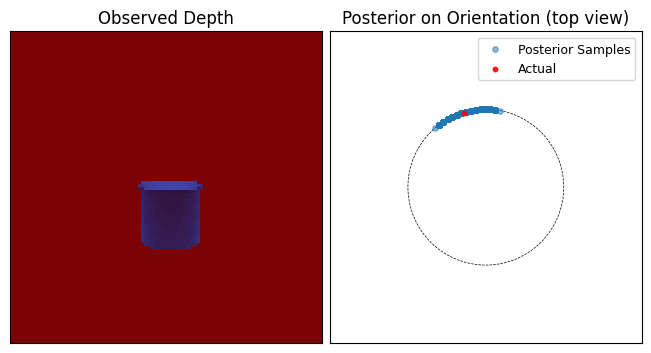

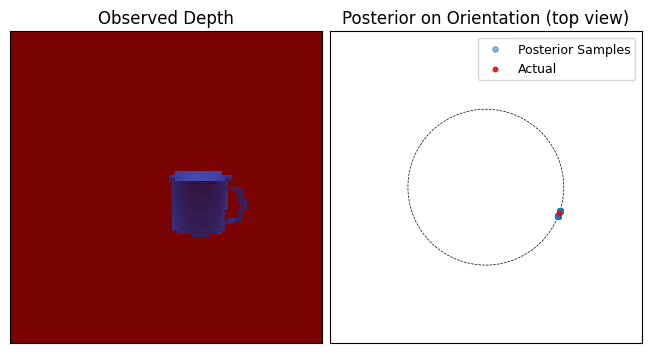

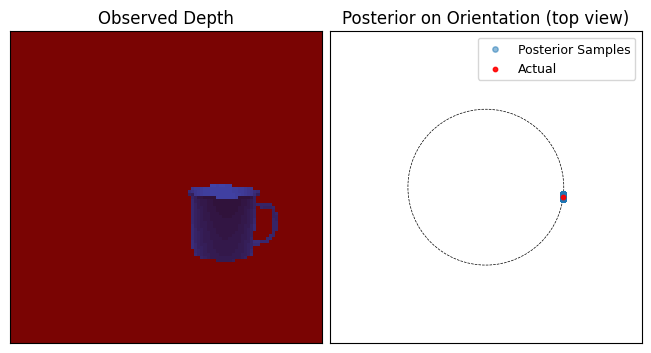

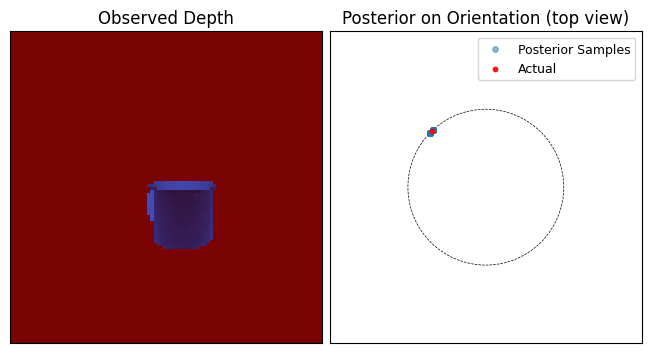

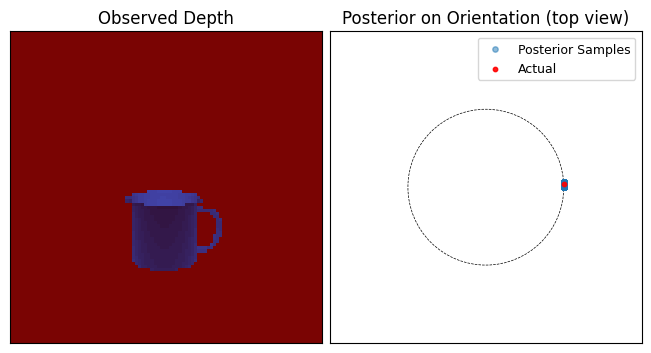

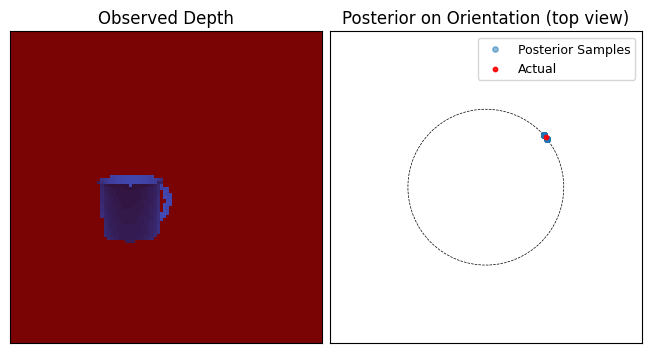

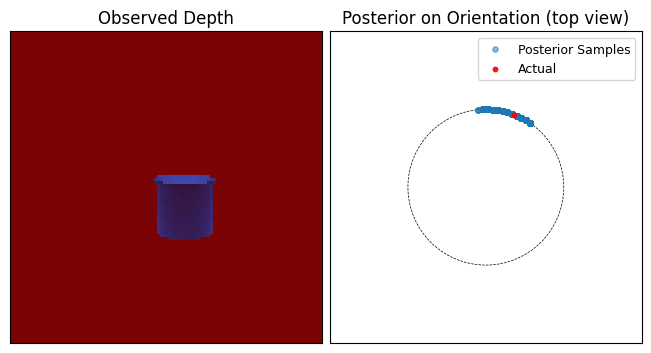

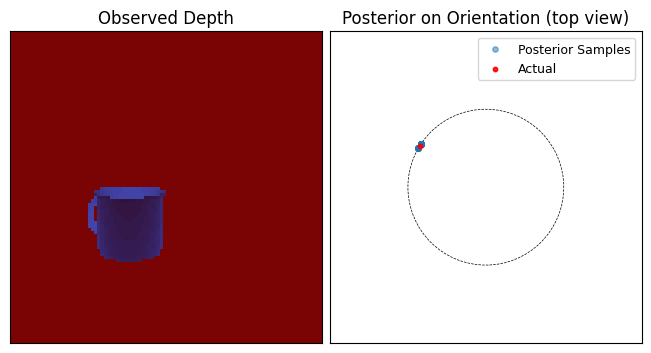

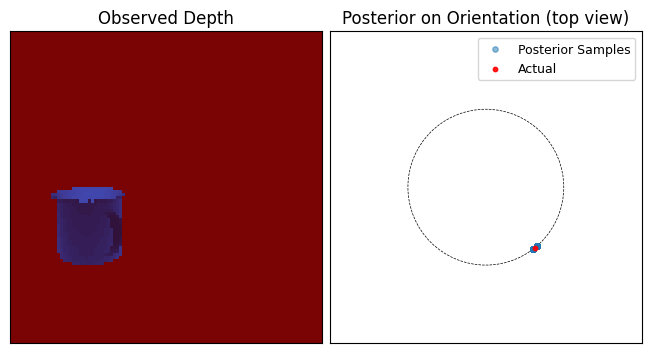

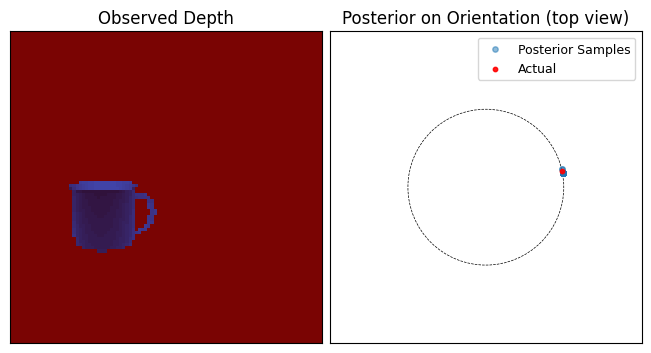

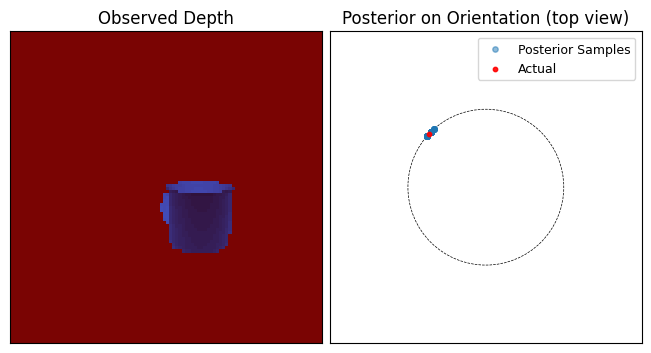

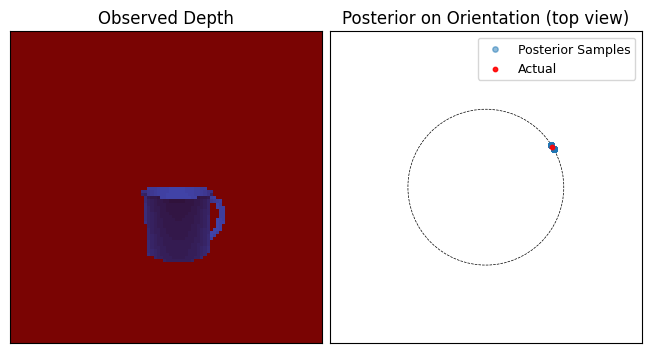

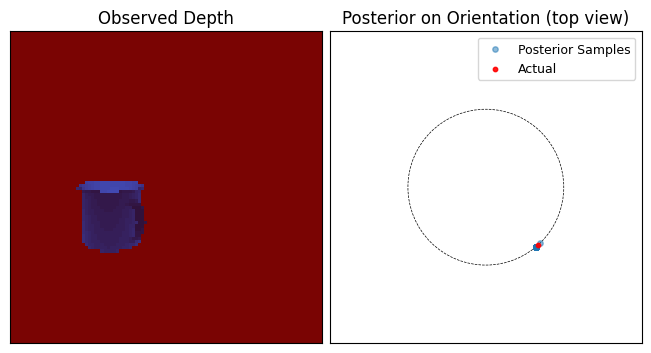

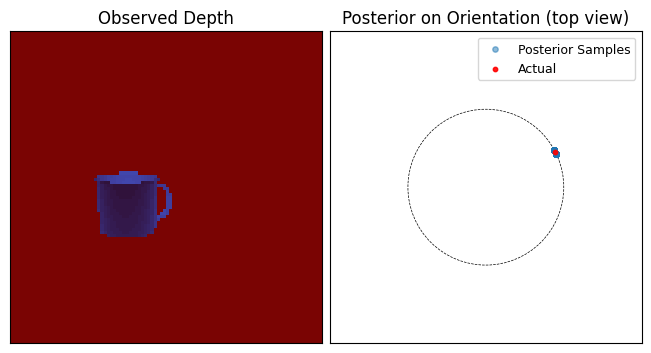

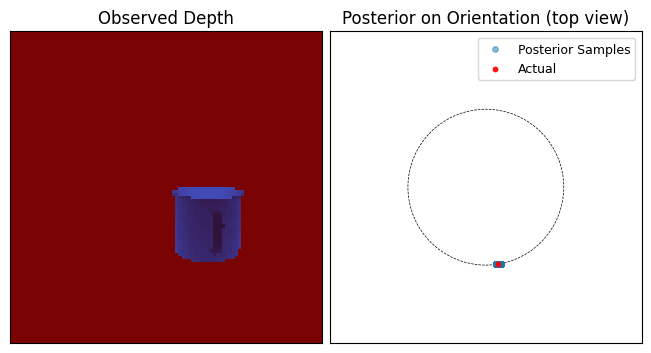

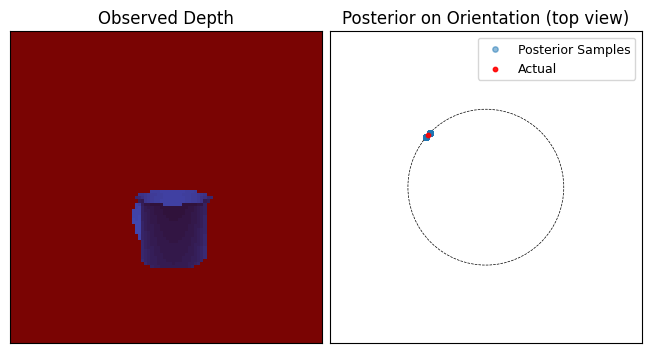

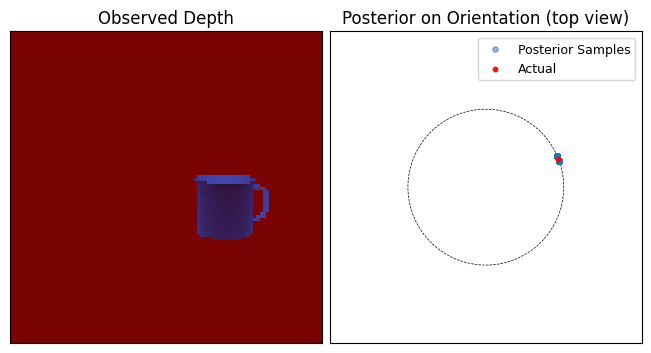

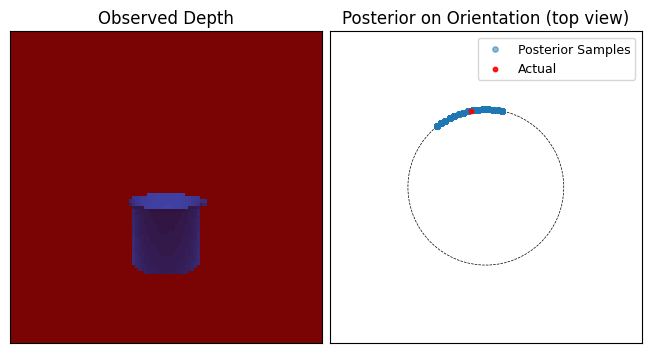

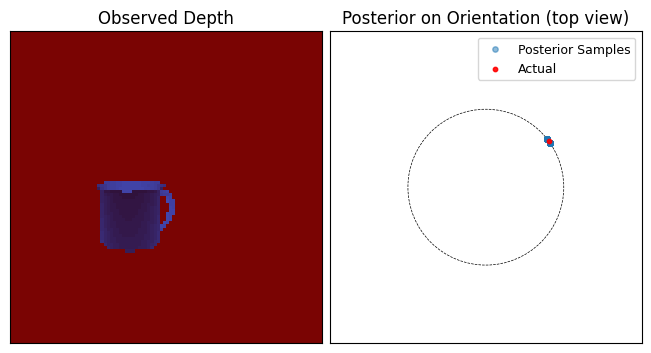

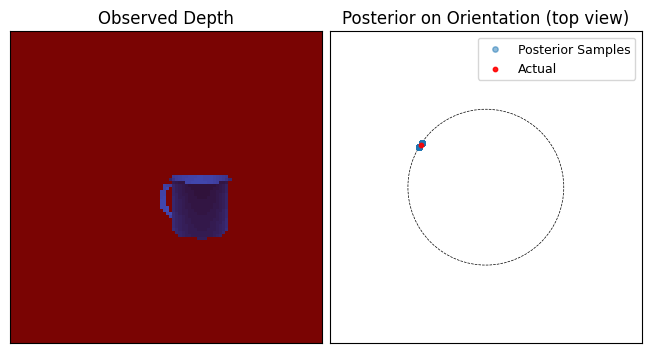

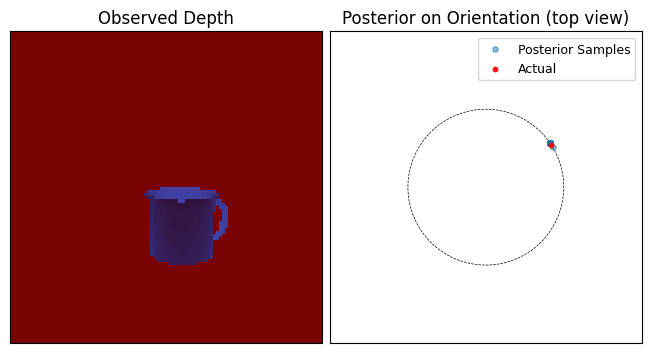

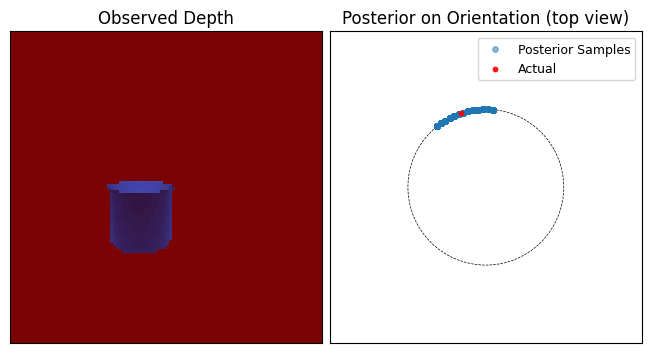

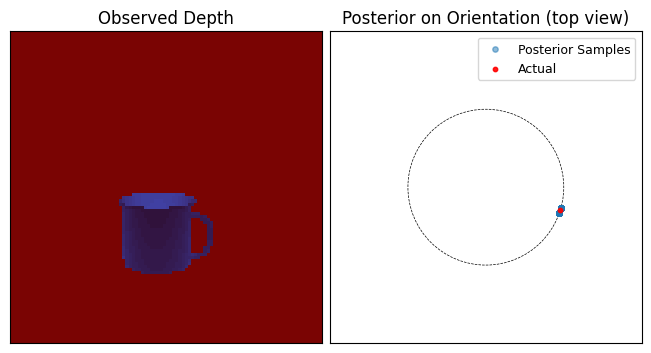

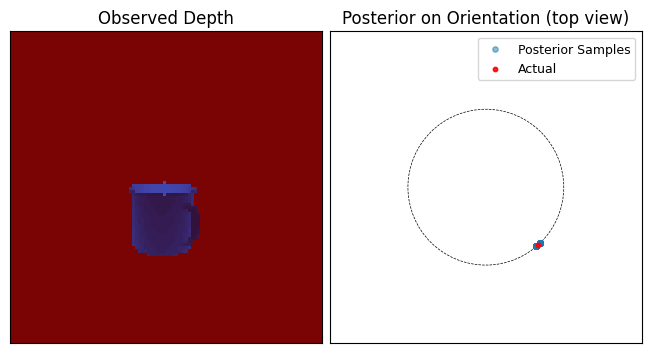

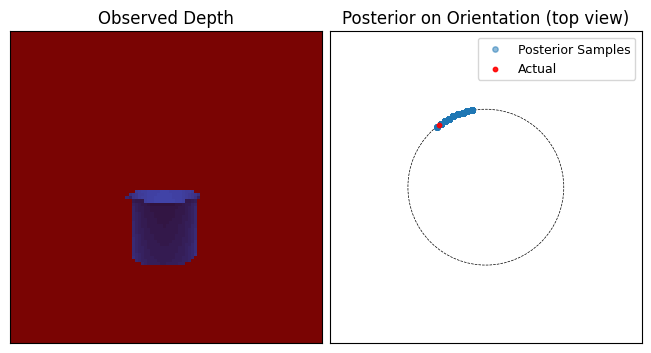

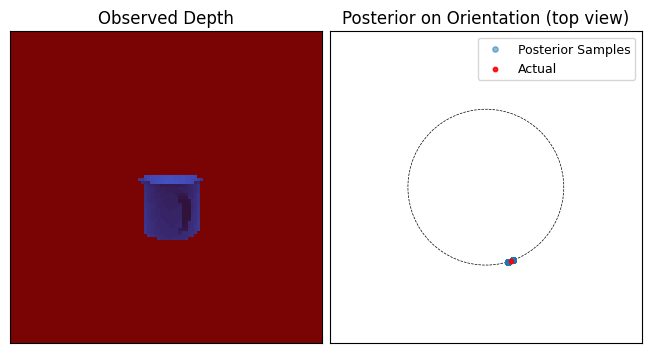

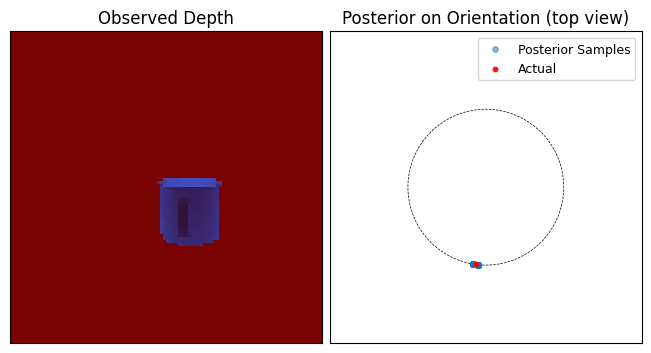

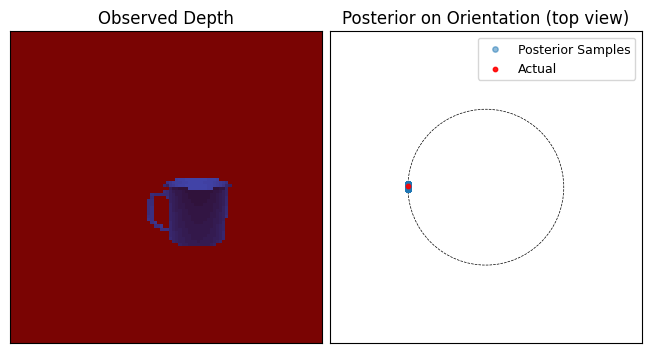

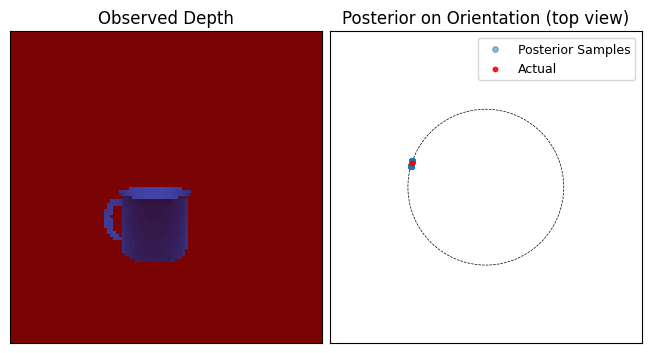

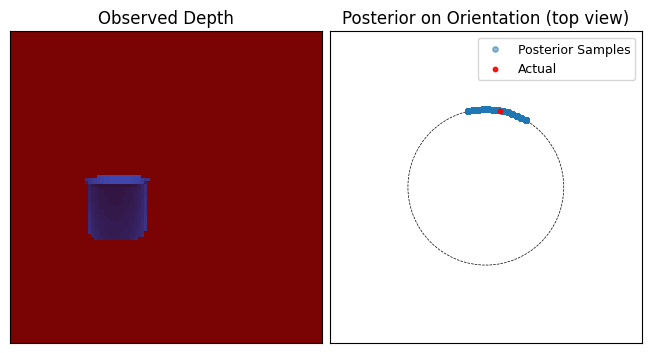

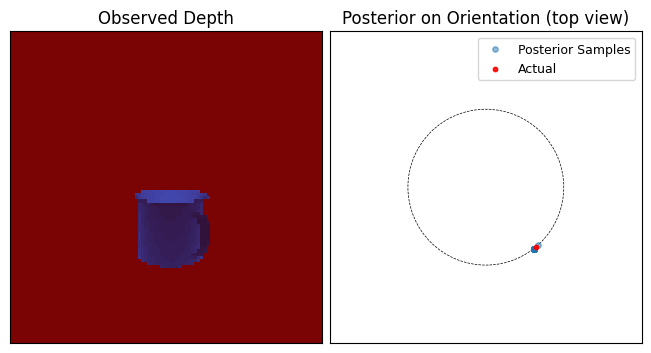

In [110]:
pathlib.Path('mug_results').mkdir(parents=True, exist_ok=True) 
NUM_IMAGES = 50
for experiment_iteration in tqdm(range(NUM_IMAGES)):
    key = jax.random.split(key, 1)[0]
    weight, trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "parent_1": 0,
        "id_0": jnp.int32(21),
        "id_1": jnp.int32(13),
        "camera_pose": jnp.eye(4),
        "root_pose_0": table_pose,
        "face_parent_1": 3,
        "face_child_1": 2,
        "variance": 0.00001,
        "outlier_prob": 0.001,
        # "contact_params_1": jnp.array([0.0, 0.0, 0.0])
    }), (
        jnp.arange(2),
        jnp.arange(22),
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.1, -0.1, -jnp.pi]), jnp.array([0.1, 0.1, jnp.pi])]),
        b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
    )
    b.show_trimesh("1", b.RENDERER.meshes[13])
    b.set_pose("1", b.genjax.get_poses(trace)[1])
    
    contact_param_grid = trace["contact_params_1"] + contact_param_deltas
    weights =  jnp.concatenate([
        enumerators[3](trace, key, cp)
        for cp in jnp.array_split(contact_param_grid, 50)
    ],axis=0)
    sampled_indices = jnp.unravel_index(jax.random.categorical(key, weights.reshape(-1), shape=(1000,)), weights.shape)[0]
    sampled_contact_params = contact_param_grid[sampled_indices]
    
    fig = make_orientation_posterior_viz(trace["image"], trace["contact_params_1"], sampled_contact_params)
    fig.savefig(f'mug_results/{1:05d}.png')


In [111]:
import imageio
images = [imageio.imread(f'mug_results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(NUM_IMAGES))]
imageio.mimsave("mug_results.gif", images, 'GIF', duration=1200)

  0%|                                                                 | 0/50 [00:00<?, ?it/s]/var/tmp/ipykernel_3952339/2736872436.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'mug_results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(NUM_IMAGES))]


FileNotFoundError: No such file: '/home/nishadgothoskar/bayes3d/scripts/experiments/icra/mug/mug_results/00020.png'

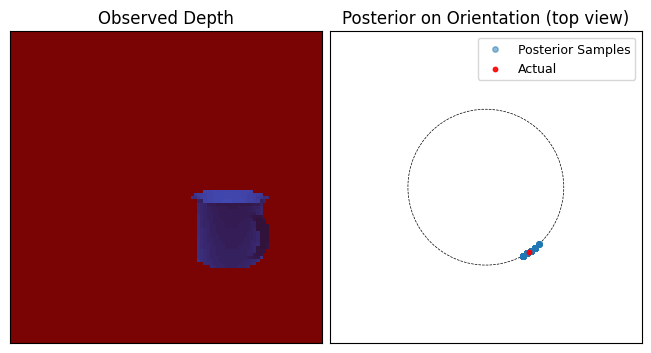

In [44]:
enumerators[1](trace,key, sampled_contact_params[0])

Array(52972.4, dtype=float32)

In [42]:
weights.max()

Array(18434.973, dtype=float32)

In [27]:
trace["contact_params_1"]

Array([ 0.004058  , -0.08801203,  2.4961703 ], dtype=float32)